# Policy Optimization with Multiple Optima for 0-1 Knapsack Problem

> 1. [Kool, W., Hoof, H. van, & Welling, M. (2019). Attention, Learn to Solve Routing Problems! _ICLR 2019_.](https://openreview.net/forum?id=ByxBFsRqYm)
> 2. [Kwon, Y.-D., Choo, J., Kim, B., Yoon, I., Gwon, Y., & Min, S. (2020). POMO: Policy Optimization with Multiple Optima for Reinforcement Learning. _NeurIPS 2020_.](https://proceedings.neurips.cc/paper_files/paper/2020/hash/f231f2107df69eab0a3862d50018a9b2-Abstract.html)


## Initialize


In [39]:
import os
import platform
from packaging import version
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# Utility functions defined in `utils.py`
from utils import dict_to_namespace, read_toml, seed_everything

device_name = platform.node()
if device_name == 'nedsmac.local':
    CONFIG_DIR = 'configs'
    OUTPUT_DIR = 'output'
else:
    CONFIG_DIR = '/code/configs'
    OUTPUT_DIR = '/output'

config_files = sorted(os.listdir(CONFIG_DIR))
configs = {
    filename.split('.')[0]: dict_to_namespace(
        read_toml(os.path.join(CONFIG_DIR, filename))
    )
    for filename in config_files
    if filename.endswith('.toml')
}
DEBUG = False

print(f'TensorFlow version: {tf.version.VERSION}')
if not DEBUG:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.get_logger().setLevel('ERROR')
physical_gpus = tf.config.list_physical_devices('GPU')
for gpu in physical_gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(f'GPU: {logical_gpus}')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
TensorFlow version: 2.13.0-rc0
GPU: []


## Dataset


In [40]:
def random_problem_dataset(
    num_items, batch_size, min_c2n=25, max_c2n=25, uniform_w=True
):
    def generator():
        while True:
            c = tf.cast(
                tf.random.uniform(
                    (batch_size,),
                    num_items * min_c2n,
                    num_items * max_c2n + 1,
                    dtype=tf.int32,
                ),
                tf.float32,
            )
            if uniform_w:
                w = tf.cast(
                    tf.random.uniform((batch_size, num_items), 1, 100, dtype=tf.int32),
                    tf.float32,
                )
            else:
                min_w = tf.random.uniform([], 5, 30)
                max_w = tf.random.uniform([], 70, 200)
                w = tf.random.uniform((batch_size, num_items), min_w, max_w)
            v = tf.cast(
                tf.random.uniform((batch_size, num_items), 1, 100, dtype=tf.int32),
                tf.float32,
            )
            yield c, w, v

    return tf.data.Dataset.from_generator(
        generator,
        (tf.float32, tf.float32, tf.float32),
        ((batch_size,), (batch_size, num_items), (batch_size, num_items)),
    ).prefetch(1)

## Encoder


In [41]:
class Encoder(tf.keras.Model):
    class Layer(tf.keras.layers.Layer):
        def __init__(self, embed_dim, key_dim, num_heads, hidden_dim, **kwargs):
            super().__init__(**kwargs)
            self.mha = tf.keras.layers.MultiHeadAttention(
                num_heads, key_dim, name='mha'
            )
            self.ffn = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(hidden_dim, activation='relu', name='dense1'),
                    tf.keras.layers.Dense(embed_dim, name='dense2'),
                ],
                name='ffn',
            )
            self.norm1 = tf.keras.layers.BatchNormalization(name='norm1')
            self.norm2 = tf.keras.layers.BatchNormalization(name='norm2')

        def call(self, input):
            mha_output = self.mha(input, input, input)
            hidden = self.norm1(input + mha_output)
            ffn_output = self.ffn(hidden)
            return self.norm2(hidden + ffn_output)

    def __init__(
        self, embed_dim, key_dim, num_heads, hidden_dim, num_layers=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Dense(embed_dim, name='embedding')
        self.transformer_layers = [
            self.Layer(embed_dim, key_dim, num_heads, hidden_dim, name=f'layer_{i}')
            for i in range(num_layers)
        ]

    def call(self, item_data):
        item_embeddings = self.embedding(item_data)
        for layer in self.transformer_layers:
            item_embeddings = layer(item_embeddings)
        return item_embeddings

## Decoder


In [42]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, key_dim, num_heads, logit_limit, **kwargs):
        super().__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim, name='mha'
        )
        self.scaling = tf.keras.layers.Lambda(
            lambda x: x / tf.sqrt(tf.cast(embed_dim, tf.float32)), name='scaling'
        )
        self.clipping = tf.keras.layers.Lambda(
            lambda x: tf.tanh(x) * logit_limit, name='clipping'
        )
        self.softmax = tf.keras.layers.Softmax()

    def call(self, item_embeddings, item_mask, context_embedding):
        # context_embeddings: (batch_size, num_items, ?)
        # item_embeddings: (batch_size, num_items, embed_dim)
        # item_mask: (batch_size, group_size, num_items)
        # mha_output: (batch_size, group_size, embed_dim)
        mha_output = self.mha(
            context_embedding, item_embeddings, item_embeddings, item_mask
        )
        # score: (batch_size, group_size, num_items)
        score = tf.matmul(mha_output, item_embeddings, transpose_b=True)
        score = self.clipping(self.scaling(score))
        return self.softmax(score, item_mask)

## REINFORCE Agent with Built-in Environment Definition


In [43]:
class Agent(tf.keras.Model):
    def __init__(
        self,
        group_size,
        embed_dim,
        key_dim,
        num_heads,
        hidden_dim,
        num_layers,
        logit_limit,
    ):
        super().__init__()
        self.encoder = Encoder(
            embed_dim, key_dim, num_heads, hidden_dim, num_layers, name='encoder'
        )
        self.decoder = Decoder(
            embed_dim, key_dim, num_heads, logit_limit, name='decoder'
        )

        self.batch_size = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.group_size = group_size
        self.num_items = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.capacity = tf.Variable(
            initial_value=tf.zeros((0,)), shape=(None,), trainable=False
        )
        self.item_data = tf.Variable(
            initial_value=tf.zeros((0, 0, 2)),
            shape=(None, None, 2),
            trainable=False,
        )
        self.current_value = tf.Variable(
            initial_value=tf.zeros((0, self.group_size)),
            shape=(None, self.group_size),
            trainable=False,
        )
        self.current_capacity = tf.Variable(
            initial_value=tf.zeros((0, self.group_size)),
            shape=(None, self.group_size),
            trainable=False,
        )
        self.item_mask = tf.Variable(
            initial_value=tf.zeros((0, self.group_size, 0), dtype=tf.bool),
            shape=(None, self.group_size, None),
            dtype=tf.bool,
            trainable=False,
        )
        self.finished = tf.Variable(
            initial_value=tf.zeros((0, self.group_size), dtype=tf.bool),
            shape=(None, self.group_size),
            dtype=tf.bool,
            trainable=False,
        )
        self.build((None,))

    def call(self, _):
        self.decode(self.encode())
        return None

    def encode(self, training=None):
        item_embeddings = self.encoder(self.item_data[:, :-1, :], training=training)
        return item_embeddings

    def decode(self, item_embeddings, training=None):
        context_embedding = self.current_capacity[..., tf.newaxis]
        probs = self.decoder(
            item_embeddings,
            self.item_mask,
            context_embedding,
            training=training,
        )
        log_probs = tf.reshape(tf.math.log(probs + 1e-8), (-1, self.num_items))
        if training:
            action = tf.random.categorical(log_probs, 1, dtype=tf.int32)[..., 0]
        else:
            action = tf.cast(tf.argmax(log_probs, axis=-1), tf.int32)
        selected_log_probs = tf.gather_nd(
            log_probs,
            tf.stack((tf.range(self.batch_size * self.group_size), action), axis=-1),
        )
        action = tf.reshape(action, (self.batch_size, self.group_size))
        selected_log_probs = tf.reshape(
            selected_log_probs, (self.batch_size, self.group_size)
        )
        action = tf.where(self.finished, self.num_items, action)
        selected_log_probs = tf.where(
            self.finished, tf.zeros_like(selected_log_probs), selected_log_probs
        )
        return action, selected_log_probs

    def init_env(self, problem_data):
        capacity = problem_data[0]
        weight = problem_data[1]
        value = problem_data[2]
        self.capacity.assign(capacity)
        self.batch_size.assign(tf.shape(weight)[0])
        self.num_items.assign(tf.shape(weight)[1])
        # item_data: (batch_size, num_items, 2) -> (batch_size, num_items + 1, 2)
        item_data = tf.stack((weight, value), axis=-1)
        dummy_item_data = tf.zeros((self.batch_size, 1, 2))
        item_data = tf.concat((item_data, dummy_item_data), axis=1)
        self.item_data.assign(item_data)

    def init_state(self):
        # current_value: (batch_size, group_size)
        self.current_value.assign(tf.zeros((self.batch_size, self.group_size)))
        # current_capacity: (batch_size, group_size)
        self.current_capacity.assign(
            tf.ones((self.batch_size, self.group_size)) * self.capacity[:, tf.newaxis]
        )
        # item_mask: (batch_size, group_size, num_items)
        self.item_mask.assign(
            tf.ones((self.batch_size, self.group_size, self.num_items), dtype=tf.bool)
        )
        # finished: (batch_size, group_size)
        self.finished.assign(
            tf.zeros((self.batch_size, self.group_size), dtype=tf.bool)
        )

    def update_state(self, action):
        # selected_items: (batch_size, group_size, 1)
        selected_items = tf.expand_dims(action, axis=-1)
        # selected_item_data: (batch_size, group_size, 2)
        selected_item_data = tf.gather_nd(self.item_data, selected_items, batch_dims=1)
        # current_value: (batch_size, group_size)
        self.current_value.assign_add(selected_item_data[..., 1])
        # current_capacity: (batch_size, group_size)
        self.current_capacity.assign_sub(selected_item_data[..., 0])
        # selected_item_mask: (batch_size, group_size, num_items + 1)
        selected_item_mask = tf.cast(tf.one_hot(action, self.num_items + 1), tf.bool)
        self.item_mask.assign(
            tf.logical_and(self.item_mask, tf.logical_not(selected_item_mask[..., :-1]))
        )
        fit_item_mask = tf.greater_equal(
            self.current_capacity[..., tf.newaxis],
            self.item_data[:, tf.newaxis, :-1, 0],
        )
        self.item_mask.assign(tf.logical_and(self.item_mask, fit_item_mask))
        # finished: (batch_size, group_size)
        self.finished.assign(
            tf.logical_or(
                self.finished, tf.logical_not(tf.reduce_any(self.item_mask, axis=-1))
            )
        )
        self.item_mask.assign(
            tf.logical_or(self.item_mask, self.finished[..., tf.newaxis])
        )

    def init(self, problem_data):
        self.init_env(problem_data)
        self.init_state()
        initial_action = tf.repeat(
            tf.range(self.group_size, dtype=tf.int32)[tf.newaxis, :],
            self.batch_size,
            axis=0,
        )
        self.update_state(initial_action)
        return initial_action

    def forward(self, training=None):
        item_embeddings = self.encode(training=training)

        def loop_cond(_):
            return tf.logical_not(tf.reduce_all(self.finished))

        def loop_body(log_likelihood):
            action, selected_log_probs = self.decode(item_embeddings, training=training)
            self.update_state(action)
            return [log_likelihood + selected_log_probs]

        log_likelihood = tf.zeros((self.batch_size, self.group_size))
        log_likelihood = tf.while_loop(
            loop_cond,
            loop_body,
            loop_vars=[log_likelihood],
            parallel_iterations=1,
            maximum_iterations=self.num_items,
        )[0]

        baseline = tf.reduce_mean(self.current_value, axis=-1, keepdims=True)
        advantage = self.current_value - baseline
        loss = -tf.reduce_mean(log_likelihood * advantage)
        return loss

    def train_step(self, problem_data):
        ### Initialize
        self.init(problem_data)
        ### Solve
        with tf.GradientTape() as tape:
            loss = self.forward(training=True)
        ### Backprop
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss, "value": tf.reduce_mean(self.current_value)}

    def test_step(self, problem_data):
        ### Initialize
        self.init(problem_data)
        ### Solve
        loss = self.forward(training=False)
        return {"loss": loss, "value": tf.reduce_mean(self.current_value)}

    def fit(self, train_ds, steps_per_epoch=10, num_epochs=100, **kwargs):
        super().fit(
            x=train_ds,
            y=None,
            validation_data=train_ds,
            validation_steps=steps_per_epoch,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            batch_size=None,
            **kwargs,
        )

    def save_weights(self, filepath, **kwargs):
        parts = filepath.split('.')
        decoder_path = '.'.join(parts[:-1] + ['decoder'] + parts[-1:])
        self.encoder.save_weights(filepath, **kwargs)
        self.decoder.save_weights(decoder_path, **kwargs)

    def load_weights(self, filepath, **kwargs):
        parts = filepath.split('.')
        decoder_path = '.'.join(parts[:-1] + ['decoder'] + parts[-1:])
        self.encoder.load_weights(filepath, **kwargs)
        self.decoder.load_weights(decoder_path, **kwargs)

    def solve(self, problem_data):
        # initial_action = self.init(problem_data)
        # trajectories = [initial_action.numpy()]
        self.init_env(problem_data)
        self.init_state()
        trajectories = []
        item_embeddings = self.encode(training=False)
        while not tf.reduce_all(self.finished):
            action, _ = self.decode(item_embeddings, training=False)
            self.update_state(action)
            trajectories.append(action.numpy())
        values = self.current_value.numpy()
        best_indices = np.argmax(values, axis=-1)
        best_values = values[np.arange(len(values)), best_indices]
        trajectories = np.stack(trajectories, axis=-1)
        best_trajectories = [t[best_indices[i]] for i, t in enumerate(trajectories)]
        best_trajectories = [t[t != self.num_items] for t in best_trajectories]
        solutions = [
            ''.join(['1' if i in t else '0' for i in range(self.num_items.numpy())])
            for t in best_trajectories
        ]
        return solutions, best_values, best_trajectories

## Training


In [44]:
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard, CSVLogger


def run_experiment(name, config):
    seed_everything(config.seed)

    # prepare data
    dataset = random_problem_dataset(
        num_items=config.num_items,
        batch_size=config.batch_size,
        min_c2n=5,
        max_c2n=35,
        uniform_w=False,
    )

    # create model
    model = Agent(
        group_size=config.group_size,
        embed_dim=config.item_dim,
        key_dim=config.key_dim,
        num_heads=config.num_heads,
        hidden_dim=config.hidden_dim,
        num_layers=config.num_layers,
        logit_limit=config.logit_limit,
    )

    # use checkpoint or train model
    ckpt_path = os.path.join(OUTPUT_DIR, name, 'checkpoint.keras')
    csv_path = os.path.join(OUTPUT_DIR, name, 'loss.csv')
    log_path = os.path.join(OUTPUT_DIR, name, 'logs')
    if os.path.exists(ckpt_path):
        print(f'Using pre-trained model at {ckpt_path}')
        model.load_weights(ckpt_path)
    else:
        print(f'Training model {name}')

        if config.optimizer == 'sgd':
            optimizer = SGD(
                learning_rate=config.learning_rate, weight_decay=config.weight_decay
            )
        elif config.optimizer == 'adam':
            if version.parse(tf.version.VERSION) <= version.parse('2.12'):
                optimizer = Adam(
                    learning_rate=config.learning_rate, decay=config.weight_decay
                )
            else:
                optimizer = Adam(
                    learning_rate=config.learning_rate, weight_decay=config.weight_decay
                )
        else:
            raise NotImplementedError()

        callbacks = [CSVLogger(csv_path), TensorBoard(log_path)]

        model.compile(optimizer=optimizer, run_eagerly=DEBUG)
        model.fit(
            train_ds=dataset,
            steps_per_epoch=config.train_steps,
            num_epochs=config.num_epochs,
            callbacks=callbacks,
        )
        model.save_weights(ckpt_path)
        print(f'Saved model at {ckpt_path}')

    return model


# Training
for name, config in configs.items():
    print('=' * 80)
    print(f'Running experiment: {name}')
    display(vars(config))
    run_experiment(name, config)
print('=' * 80)

Running experiment: DEBUG


{'seed': 42,
 'num_items': 50,
 'group_size': 50,
 'item_dim': 32,
 'key_dim': 16,
 'num_heads': 4,
 'hidden_dim': 64,
 'num_layers': 2,
 'logit_limit': 10.0,
 'train_steps': 5,
 'batch_size': 64,
 'num_epochs': 200,
 'optimizer': 'adam',
 'learning_rate': 8e-05,
 'weight_decay': 1e-07}

Using pre-trained model at output/DEBUG/checkpoint.keras


## Learning Curve


Plotting loss for DEBUG


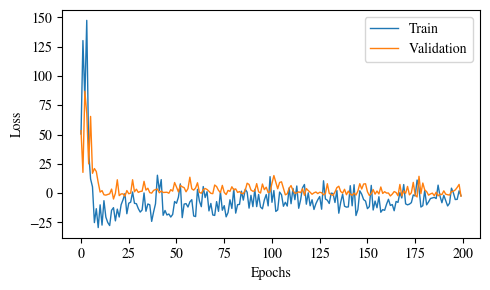

In [45]:
import matplotlib.pyplot as plt

for name in configs.keys():
    print('=' * 80)
    print(f'Plotting loss for {name}')
    csv_path = os.path.join(OUTPUT_DIR, name, 'loss.csv')
    if not os.path.exists(csv_path):
        print(f'No logs found for {name}, skipping')
        continue

    logs = pd.read_csv(csv_path)
    plt.figure(figsize=(5, 3))
    plt.plot(logs['loss'], label='Train')
    plt.plot(logs['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/lab3_loss.svg', bbox_inches='tight')
    plt.show()
print('=' * 80)

## Evaluation


In [46]:
name, config = list(configs.items())[0]
test_data = list(
    random_problem_dataset(config.group_size, 1).take(100).as_numpy_iterator()
)
config.group_size = 1
model = run_experiment(name, config)

Using pre-trained model at output/DEBUG/checkpoint.keras


In [47]:
from ctypes import *
from time import time
from itertools import chain
from joblib import Parallel, delayed


class CSolver:
    def __init__(self, path):
        self.clib = CDLL(path)
        self.clib.solve.restype = c_float

    def solve(self, n, c, w, v, *args):
        n = c_int(n)
        c = c_int(c)
        w = w.ctypes.data_as(POINTER(c_int))
        v = v.ctypes.data_as(POINTER(c_int))
        m = c_int(0)
        x = np.zeros(n.value, dtype=np.int32).ctypes.data_as(POINTER(c_int))
        t = self.clib.solve(n, c, w, v, byref(m), x, *args)
        return m.value, t * 1000, x[: n.value]


class DPSolver(CSolver):
    def __init__(self):
        super().__init__('lib/dynamic_programming.dylib')


class GreedySolver(CSolver):
    def __init__(self):
        super().__init__('lib/greedy.dylib')


class MCSolver(CSolver):
    def __init__(self, *, max_T, min_T, budget, seed):
        super().__init__('lib/monte_carlo.dylib')
        self.max_T = max_T
        self.min_T = min_T
        self.budget = budget
        self.seed = seed

    def solve(self, n, c, w, v):
        return super().solve(
            # fmt: off
            n, c, w, v,
            # fmt: on
            c_float(self.max_T),
            c_float(self.min_T),
            c_float(self.budget),
            c_uint(self.seed),
        )


def c_solve(name: str, n, c, w, v, *, budget=0.2, max_T=1, min_T=0, seed=42):
    if name == 'Dynamic Programming':
        solver = DPSolver()
    elif name == 'Greedy':
        solver = GreedySolver()
    elif name == 'Monte Carlo':
        solver = MCSolver(budget=budget, max_T=max_T, min_T=min_T, seed=seed)
    m, t, x = solver.solve(n, c, w, v)
    result = {'Value': m, 'Time (ms)': t, 'Solution': ''.join(map(str, x))}
    return result


def run_baselines(trial):
    n = test_data[trial][1].shape[1]
    c = test_data[trial][0].astype(np.int32)[0]
    w = test_data[trial][1].astype(np.int32)[0]
    v = test_data[trial][2].astype(np.int32)[0]
    return [
        {'Trial': trial, 'Name': name, **c_solve(name, n, c, w, v)}
        for name in ['Dynamic Programming', 'Greedy', 'Monte Carlo']
    ]


results = Parallel(n_jobs=-1, prefer='threads')(
    delayed(run_baselines)(trial) for trial in range(len(test_data))
)
results = pd.DataFrame(list(chain.from_iterable(results)))
results.set_index(['Trial', 'Name'], inplace=True)
real_solutions = results.groupby('Trial')['Value'].max().to_list()
results['Optimality Gap'] = results.groupby('Name')['Value'].transform(
    lambda x: 1 - x / real_solutions
)
for i, (c, w, v) in enumerate(test_data):
    print('=' * 80)
    print(f'Trial {i}')
    start = time()
    solution, value, _ = model.solve((c, w, v))
    end = time()
    elapsed = (end - start) * 1000
    solution, value = solution[0], value[0]
    real_value = results.loc[(i, "Dynamic Programming"), "Value"]
    optimality_gap = 1 - value / real_value
    print(f'Time (ms)          = {elapsed}')
    print(f'Value / Real Value = {value} / {real_value}')
    print(f'Solution           = {solution}')
    print(f'Optimality Gap     = {optimality_gap}')
    result = {
        'Trial': i,
        'Name': 'Neural Network',
        'Value': value,
        'Time (ms)': elapsed,
        'Solution': solution,
        'Optimality Gap': optimality_gap,
    }
    results = pd.concat([results, pd.DataFrame([result]).set_index(['Trial', 'Name'])])
print('=' * 80)
stats = results.groupby('Name')[['Time (ms)', 'Optimality Gap']].mean()
display(stats)
display(results)

Trial 0
Time (ms)          = 218.5683250427246
Value / Real Value = 1997.0 / 2000
Solution           = 11000000111010001011001110011110010111010011110110
Optimality Gap     = 0.0014999999999999458
Trial 1
Time (ms)          = 188.10486793518066
Value / Real Value = 2402.0 / 2402.0
Solution           = 11111011100111001011101001011011111101011110101001
Optimality Gap     = 0.0
Trial 2
Time (ms)          = 149.0180492401123
Value / Real Value = 2251.0 / 2251.0
Solution           = 11100111110011101101010111001101010101011111110010
Optimality Gap     = 0.0
Trial 3
Time (ms)          = 119.77219581604004
Value / Real Value = 1719.0 / 1725.0
Solution           = 10110001111111100000011101011001001001100011011101
Optimality Gap     = 0.003478260869565264
Trial 4
Time (ms)          = 144.15621757507324
Value / Real Value = 2036.0 / 2036.0
Solution           = 10100101011110111011100110101001011111101010011111
Optimality Gap     = 0.0
Trial 5
Time (ms)          = 115.25201797485352
Value / Rea

,Time (ms),Optimality Gap
Name,,
Dynamic Programming,4.307870,0.000000
Greedy,0.101080,0.002984
Monte Carlo,201.337431,0.025238
Neural Network,166.811926,0.002197


Value   Time (ms)   
Trial Name                                      
0     Dynamic Programming  2000.0    0.890000  \
      Greedy               1996.0    0.099000   
      Monte Carlo          1976.0  200.115994   
1     Dynamic Programming  2402.0    0.637000   
      Greedy               2402.0    0.016000   
...                           ...         ...   
95    Neural Network       2422.0  187.000036   
96    Neural Network       2143.0  175.434113   
97    Neural Network       1852.0  134.621143   
98    Neural Network       2312.0  155.811071   
99    Neural Network       2016.0  138.218880   

                                                                    Solution   
Trial Name                                                                     
0     Dynamic Programming  0110000001101000101100111001111011011101101111...  \
      Greedy               0100010011101000101100111001111111011101001111...   
      Monte Carlo          1100000001101000101110101001111111011101001111...   
1     Dynamic Programming  1111101110011100101110100101101111110101111010...   
      Greedy               1111101110011100101110100101101111110101111010...   
...                                                                      ...   
95    Neural Network       1011111011110111111111001111011110110110110011...   
96    Neural Network       0111111101111101101100101100110111001111111110...   
97    Neural Network       0011011110001010011101111101011000001011111000...   
98    Neural Network       0100001110110101111111110110110101111111101010...   
99    Neural Network       1110111100011100010100110000111001111110110010...   

                           Optimality Gap  
Trial Name                                 
0     Dynamic Programming        0.000000  
      Greedy                     0.002000  
      Monte Carlo                0.012000  
1     Dynamic Programming        0.000000  
      Greedy                     0.000000  
...                                   ...  
95    Neural Network             0.000000  
96    Neural Network             0.000932  
97    Neural Network             0.006971  
98    Neural Network             0.002158  
99    Neural Network             0.000000  

[400 rows x 4 columns]

In [48]:
df = stats.round(4).applymap(lambda x: f'${x}$')
df.drop('Dynamic Programming', inplace=True)
df.index = [
    'Greedy Strategy',
    'Simulated Annealing',
    'Policy Optimization w/ Multiple Optima',
]
df.rename_axis('Method', inplace=True)
print(df.to_markdown(colalign=('center',) * 3))
print()

|                 Method                 |  Time (ms)  |  Optimality Gap  |
|:--------------------------------------:|:-----------:|:----------------:|
|            Greedy Strategy             |  $0.1011$   |     $0.003$      |
|          Simulated Annealing           | $201.3374$  |     $0.0252$     |
| Policy Optimization w/ Multiple Optima | $166.8119$  |     $0.0022$     |



In [49]:
sum(
    results.loc[(i, 'Neural Network'), 'Value'] > results.loc[(i, 'Greedy'), 'Value']
    for i in range(100)
), sum(
    results.loc[(i, 'Neural Network'), 'Value'] < results.loc[(i, 'Greedy'), 'Value']
    for i in range(100)
)

(37, 31)